In [11]:
# import the dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier
import qiskit
import qiskit_machine_learning
from qiskit import QuantumCircuit,QuantumRegister,ClassicalRegister
from qiskit.circuit import ParameterVector
from qiskit.utils import algorithm_globals as alg
from qiskit.circuit.library import ZZFeatureMap
from qiskit.algorithms.optimizers import SPSA
from qiskit_machine_learning.kernels import TrainableFidelityQuantumKernel
from qiskit_machine_learning.kernels.algorithms import QuantumKernelTrainer
from sklearn.metrics import classification_report

In [2]:
# read in the data
df = pd.read_csv("C:\\Datasets\\parkinson\\parkinsons.csv")

In [3]:
df.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [4]:
df.drop(['name'],axis=1,inplace=True)

In [5]:
df.isnull().sum()

MDVP:Fo(Hz)         0
MDVP:Fhi(Hz)        0
MDVP:Flo(Hz)        0
MDVP:Jitter(%)      0
MDVP:Jitter(Abs)    0
MDVP:RAP            0
MDVP:PPQ            0
Jitter:DDP          0
MDVP:Shimmer        0
MDVP:Shimmer(dB)    0
Shimmer:APQ3        0
Shimmer:APQ5        0
MDVP:APQ            0
Shimmer:DDA         0
NHR                 0
HNR                 0
status              0
RPDE                0
DFA                 0
spread1             0
spread2             0
D2                  0
PPE                 0
dtype: int64

# DATA EXPLORATION

In [6]:
df['status'].value_counts().head() 

1    147
0     48
Name: status, dtype: int64

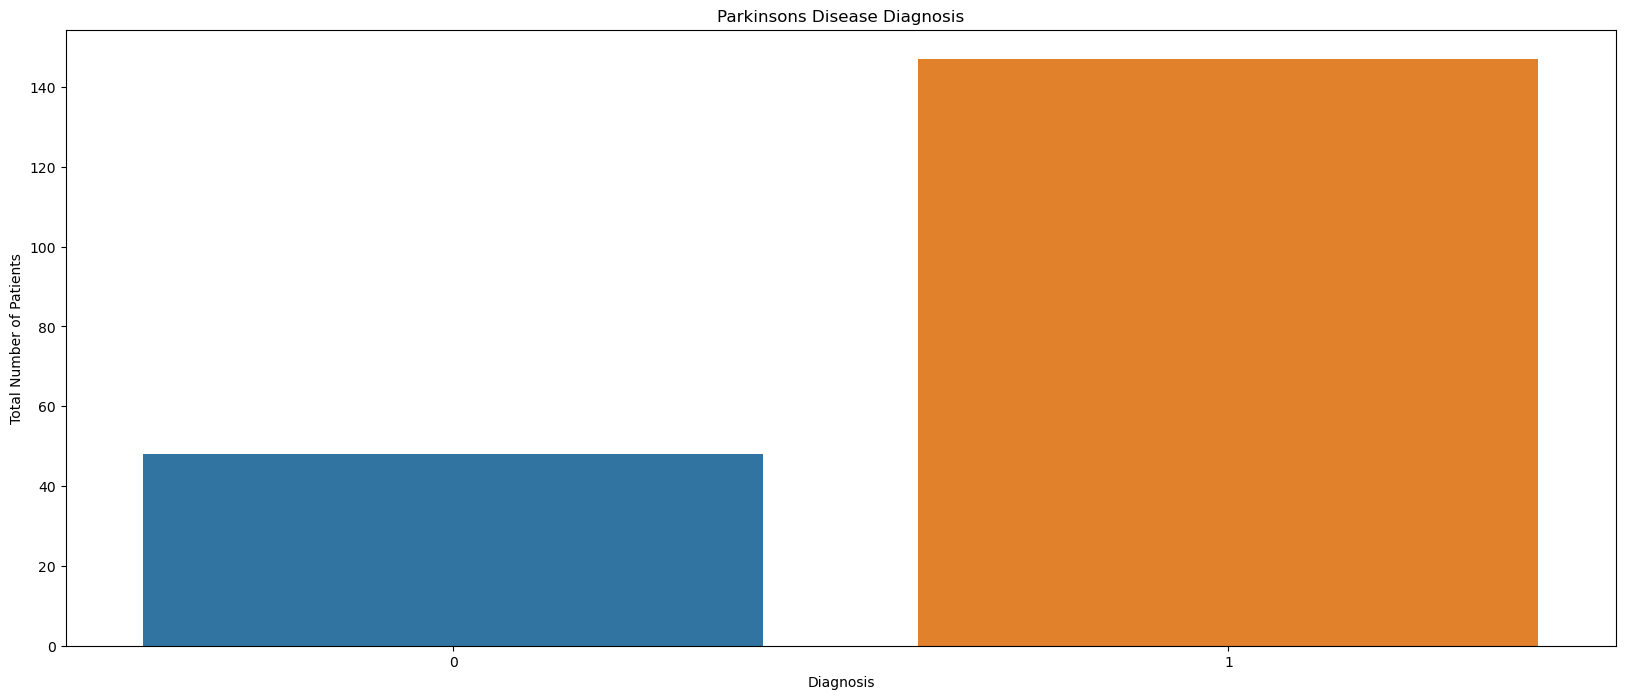

In [7]:
# Visualizing the distribution of Parkinsons Diagnosis
fig = plt.figure(figsize=(20,8))
sns.countplot(x='status',data=df)
plt.title("Parkinsons Disease Diagnosis")
plt.xlabel("Diagnosis")
plt.ylabel("Total Number of Patients")
plt.show()

In [8]:
# Correlation between features
correlation = df.corr()
correlation

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
MDVP:Fo(Hz),1.000000,0.400985,0.596546,-0.118003,-0.382027,-0.076194,-0.112165,-0.076213,-0.098374,-0.073742,...,-0.094732,-0.021981,0.059144,-0.383535,-0.383894,-0.446013,-0.413738,-0.249450,0.177980,-0.372356
MDVP:Fhi(Hz),0.400985,1.000000,0.084951,0.102086,-0.029198,0.097177,0.091126,0.097150,0.002281,0.043465,...,-0.003733,0.163766,-0.024893,-0.166136,-0.112404,-0.343097,-0.076658,-0.002954,0.176323,-0.069543
MDVP:Flo(Hz),0.596546,0.084951,1.000000,-0.139919,-0.277815,-0.100519,-0.095828,-0.100488,-0.144543,-0.119089,...,-0.150737,-0.108670,0.210851,-0.380200,-0.400143,-0.050406,-0.394857,-0.243829,-0.100629,-0.340071
MDVP:Jitter(%),-0.118003,0.102086,-0.139919,1.000000,0.935714,0.990276,0.974256,0.990276,0.769063,0.804289,...,0.746635,0.906959,-0.728165,0.278220,0.360673,0.098572,0.693577,0.385123,0.433434,0.721543
MDVP:Jitter(Abs),-0.382027,-0.029198,-0.277815,0.935714,1.000000,0.922911,0.897778,0.922913,0.703322,0.716601,...,0.697170,0.834972,-0.656810,0.338653,0.441839,0.175036,0.735779,0.388543,0.310694,0.748162
MDVP:RAP,-0.076194,0.097177,-0.100519,0.990276,0.922911,1.000000,0.957317,1.000000,0.759581,0.790652,...,0.744919,0.919521,-0.721543,0.266668,0.342140,0.064083,0.648328,0.324407,0.426605,0.670999
MDVP:PPQ,-0.112165,0.091126,-0.095828,0.974256,0.897778,0.957317,1.000000,0.957319,0.797826,0.839239,...,0.763592,0.844604,-0.731510,0.288698,0.333274,0.196301,0.716489,0.407605,0.412524,0.769647
Jitter:DDP,-0.076213,0.097150,-0.100488,0.990276,0.922913,1.000000,0.957319,1.000000,0.759555,0.790621,...,0.744901,0.919548,-0.721494,0.266646,0.342079,0.064026,0.648328,0.324377,0.426556,0.671005
MDVP:Shimmer,-0.098374,0.002281,-0.144543,0.769063,0.703322,0.759581,0.797826,0.759555,1.000000,0.987258,...,0.987626,0.722194,-0.835271,0.367430,0.447424,0.159954,0.654734,0.452025,0.507088,0.693771
MDVP:Shimmer(dB),-0.073742,0.043465,-0.119089,0.804289,0.716601,0.790652,0.839239,0.790621,0.987258,1.000000,...,0.963202,0.744477,-0.827805,0.350697,0.410684,0.165157,0.652547,0.454314,0.512233,0.695058


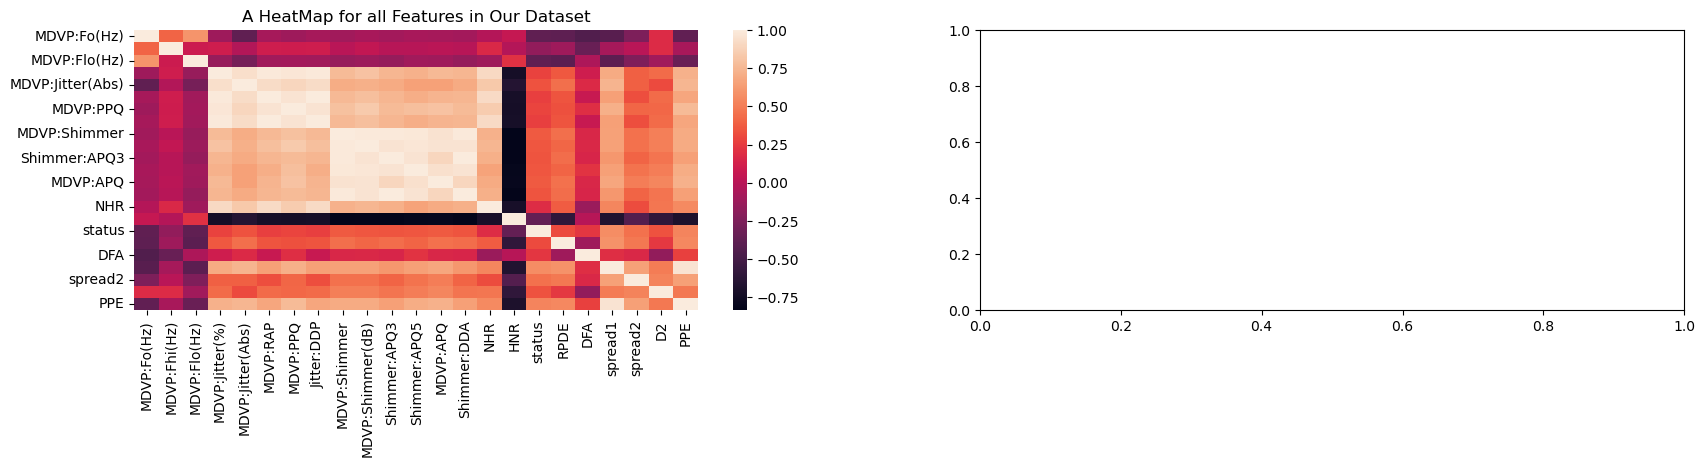

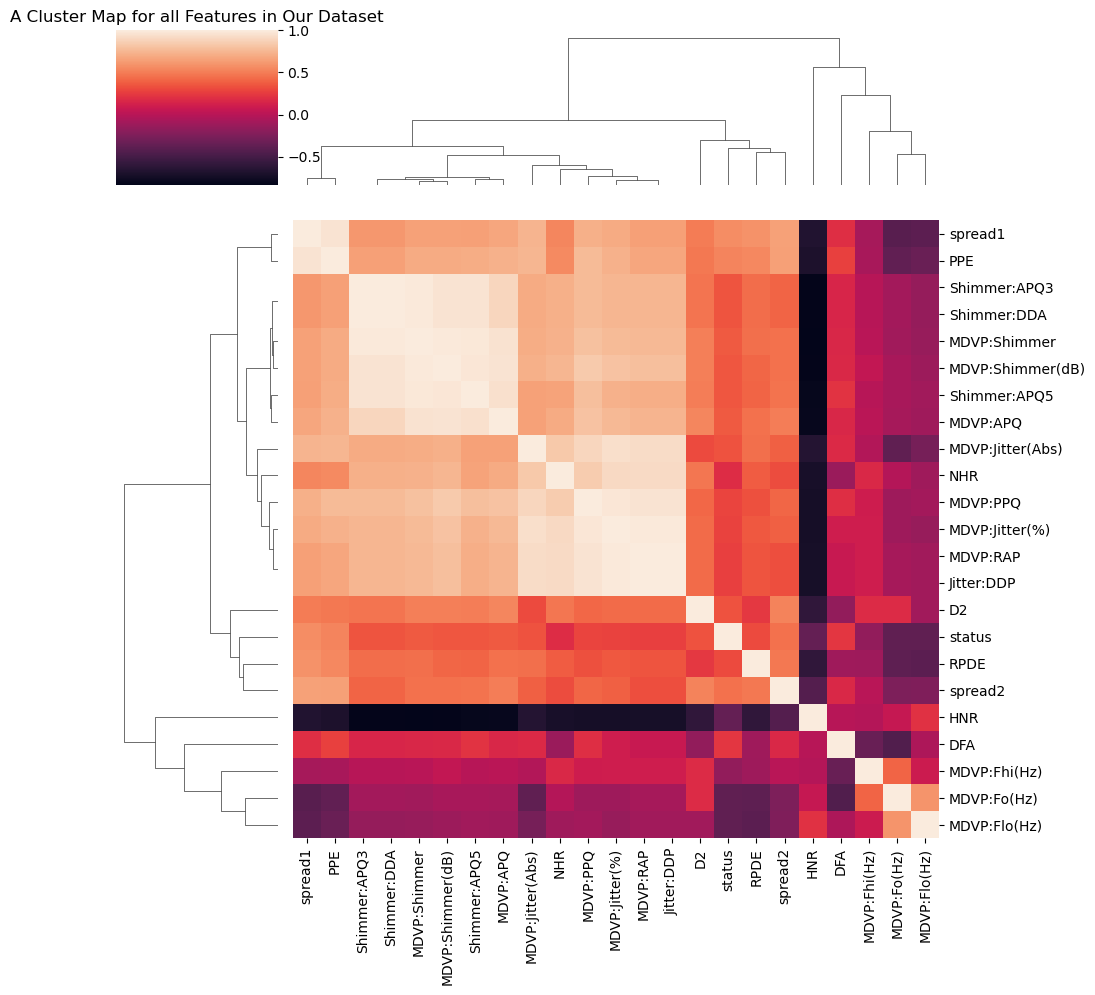

In [9]:
# Plot a Heatmap to visualize the correlation 
fig = plt.figure(figsize=(20,8))
plt.subplot(2,2,1)
sns.heatmap(correlation)
plt.title("A HeatMap for all Features in Our Dataset")
plt.subplot(2,2,2)
sns.clustermap(correlation)
plt.title("A Cluster Map for all Features in Our Dataset")
plt.tight_layout()
plt.show()

# DATA PREPROCESSING

In [12]:
X = df.drop(['status'],axis=1)
y = df['status']

In [16]:
scaler = StandardScaler()
X =scaler.fit_transform(X)
X.shape,y.shape


((195, 22), (195,))

In [17]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [18]:
X_train.shape ,y_train.shape

((156, 22), (156,))

# CLASSICAL MACHINE LEARNING

In [23]:
l_svc = LinearSVC()
l_svc.fit(X_train,y_train)
predictions = l_svc.predict(X_test)
training_score =l_svc.score(X_train,y_train)
testing_score = l_svc.score(X_test,y_test)
print(f"The Training Score for our model stands at :{training_score} and the testing score stands at :: {testing_score}")
print(f"The Classification Report for our LinearSVC Model is ;\n {classification_report(y_test,predictions)}")

The Training Score for our model stands at :0.9038461538461539 and the testing score stands at :: 0.8717948717948718
The Classification Report for out Model is ;
               precision    recall  f1-score   support

           0       0.67      0.57      0.62         7
           1       0.91      0.94      0.92        32

    accuracy                           0.87        39
   macro avg       0.79      0.75      0.77        39
weighted avg       0.87      0.87      0.87        39



In [24]:
svc = SVC()
svc.fit(X_train,y_train)
predictions = svc.predict(X_test)
training_score_svc =svc.score(X_train,y_train)
testing_score_svc = svc.score(X_test,y_test)
print(f"The Training Score for our model stands at :{training_score_svc} and the testing score stands at :: {testing_score_svc}")
print(f"The Classification Report for out SVC Model is ;\n {classification_report(y_test,predictions)}")

The Training Score for our model stands at :0.8910256410256411 and the testing score stands at :: 0.8974358974358975
The Classification Report for out SVC Model is ;
               precision    recall  f1-score   support

           0       1.00      0.43      0.60         7
           1       0.89      1.00      0.94        32

    accuracy                           0.90        39
   macro avg       0.94      0.71      0.77        39
weighted avg       0.91      0.90      0.88        39



In [26]:
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
predictions = svc.predict(X_test)
training_score_rfc =svc.score(X_train,y_train)
testing_score_rfc = svc.score(X_test,y_test)
print(f"The Training Score for our model stands at :{training_score_rfc} and the testing score stands at :: {testing_score_rfc}")
print(f"The Classification Report for out Random Forest Classifier  is ;\n {classification_report(y_test,predictions)}")

The Training Score for our model stands at :0.8910256410256411 and the testing score stands at :: 0.8974358974358975
The Classification Report for out Random Forest Classifier  is ;
               precision    recall  f1-score   support

           0       1.00      0.43      0.60         7
           1       0.89      1.00      0.94        32

    accuracy                           0.90        39
   macro avg       0.94      0.71      0.77        39
weighted avg       0.91      0.90      0.88        39



In [27]:
# Random Forest and Support Vector Classifiers perfomed better than Linear SVC .There was no overfitting as evidenced by
#The Training and Testing Scores

# QUANTUM MACHINE LEARNING 

# DEFINING THE QUANTUM FEATURE MAP

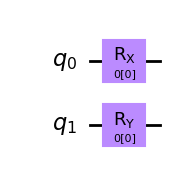

In [136]:
# Create a quantum circuit to encode our classical data in a quantum state space
training_parameters = ParameterVector("0",1)
qc = QuantumCircuit(2)
qc.rx (parameters[0],0)
qc.ry (parameters[0],1)
feature_map = ZZFeatureMap(2)
qc.compose(feature_map)
qc.draw("mpl")

# SETTING UP THE QUANTUM KERNEL AND QUANTUM KERNEL TRAINER

In [137]:
quantum_kernel = TrainableFidelityQuantumKernel(feature_map=feature_map,training_parameters=training_parameters)

In [138]:
# Create A call back function or rather a callback wrapper class

class CallBacks():
    def __init__(self):
        self._data = [[] for i in range(5)]
    def callback(self,x0,x1=None,x2=None,x3=None,x4=None):
        self._data[0].append(x0)
        self._data[1].append(x1)
        self._data[2].append(x2)
        self._data[3].append(x3)
        self._data[4].append(x4)
    def get_callback_data(self):
        return self._data
    def clear_callback_data(self):
        return [[] for i in range(5)]

In [139]:
# instantiating  the class
qkt_callback = CallBacks()
optimizer = SPSA(maxiter=10,callback=qkt_callback.callback,learning_rate=0.05,perturbation=0.05)

In [140]:
quantum_kernel_trainer = QuantumKernelTrainer(quantum_kernel=quantum_kernel,loss="svc_loss",optimizer=optimizer,
                                              initial_point=[np.pi/2])

In [141]:
X_train.shape[1]

22

In [144]:
quantum_kernel_results = quantum_kernel_trainer.fit(X_train,y_train)
#help(quantum_kernel_trainer.fit)

ValueError: could not broadcast input array from shape (3,) into shape (2,)

In [62]:
help(quantum_kernel)

Help on TrainableFidelityQuantumKernel in module qiskit_machine_learning.kernels.trainable_fidelity_quantum_kernel object:

class TrainableFidelityQuantumKernel(qiskit_machine_learning.kernels.trainable_kernel.TrainableKernel, qiskit_machine_learning.kernels.fidelity_quantum_kernel.FidelityQuantumKernel)
 |  TrainableFidelityQuantumKernel(*, feature_map: 'QuantumCircuit | None' = None, fidelity: 'BaseStateFidelity | None' = None, training_parameters: 'ParameterVector | Sequence[Parameter] | None' = None, enforce_psd: 'bool' = True, evaluate_duplicates: 'str' = 'off_diagonal') -> 'None'
 |  
 |  An implementation of the quantum kernel that is based on the
 |  :class:`~qiskit.algorithms.state_fidelities.BaseStateFidelity` algorithm and provides ability to
 |  train it.
 |  
 |  Finding good quantum kernels for a specific machine learning task is a big challenge in quantum
 |  machine learning. One way to choose the kernel is to add trainable parameters to the feature
 |  map, which can b

In [117]:
len(df.columns)

23

In [45]:
X.shape,y.shape

((195, 22), (195,))